In [17]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("abisee/cnn_dailymail", "1.0.0")

df = ds['train'].to_pandas()

In [18]:
import numpy as np
import re

us_states = {
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado",
    "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho",
    "Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana",
    "Maine","Maryland","Massachusetts","Michigan","Minnesota",
    "Mississippi","Missouri","Montana","Nebraska","Nevada",
    "New Hampshire","New Jersey","New Mexico","New York",
    "North Carolina","North Dakota","Ohio","Oklahoma","Oregon",
    "Pennsylvania","Rhode Island","South Carolina","South Dakota",
    "Tennessee","Texas","Utah","Vermont","Virginia","Washington",
    "West Virginia","Wisconsin","Wyoming","District of Columbia"
}

# Lowercase version for matching
states_lower = {s.lower() for s in us_states}

# Load the CSV
gn = pd.read_csv("global-north-countries-2026.csv")

# Normalize
gn["country"] = gn["country"].str.strip().str.lower()

# Build a set of valid countries
uk_parts = ["england", "scotland", "wales", "northern ireland", "jersey", "britain"]
valid_countries = set(gn["country"].str.lower()) | set(uk_parts)
countries_sorted = sorted(valid_countries, key=len, reverse=True)

In [19]:
country_pattern = r'\b(' + '|'.join(re.escape(c) for c in sorted(countries_sorted, key=len, reverse=True)) + r')\b'
state_pattern = r'\b(' + '|'.join(re.escape(s) for s in sorted(us_states, key=len, reverse=True)) + r')\b'


def extract_explicit_location(text):
    if pd.isna(text):
        return None

    text = text.lower()

    # Must contain "--"
    if "--" not in text:
        return None

    # Only look before "--"
    header = text.split("--", 1)[0]

     # Check word count BEFORE "--"
    words_before = header.strip().split()

    if len(words_before) > 10:
        return None  # discard if too long

    # Search for country first
    country_match = re.search(country_pattern, header)
    if country_match:
        return country_match.group(0)

    # If no country, search for US state
    state_match = re.search(state_pattern, header)
    if state_match:
        return "united states"

    return None


In [20]:
df["country"] = df["article"].apply(extract_explicit_location)

country_corrections = {
    "england": "united kingdom",
}

df["country"] = df["country"].replace(country_corrections)

# Keep only explicitly labeled rows
df_explicit = df[df["country"].notna()].copy()

n_missing = df["country"].isna().sum()
total = len(df)

print(f"Missing: {n_missing} ({n_missing/total:.2%})")
print("Number of rows:", len(df_explicit))

Missing: 276752 (96.39%)
Number of rows: 10361


In [21]:
gn_lookup = dict(zip(gn["country"], gn["GlobalNorthCountriesPartOfGlobalNorth"]))

df_explicit["global_north"] = df_explicit["country"].map(gn_lookup)

In [22]:
df_explicit.sample(20)[["article", "country", "global_north"]]

,article,country,global_north
24844,"Johannesburg, South Africa (CNN) -- A lawyer b...",south africa,No
11779,"Kathmandu, Nepal (CNN) -- Facing political pre...",nepal,No
48070,"LONDON, England (CNN) -- More than half of ch...",united kingdom,Yes
57547,"BAGHDAD, Iraq (CNN) -- Adm. William Fallon has...",iraq,No
45026,"Islamabad, Pakistan (CNN) -- Outraged Pakistan...",pakistan,No
10029,"Rome, Italy (CNN) -- The founder of a Mexican ...",italy,Yes
49000,"Bangkok, Thailand (CNN) -- Two explosions rock...",thailand,No
58936,"NEWARK, New Jersey (CNN) -- Two people, includ...",jersey,NaN
9601,"Port-au-Prince, Haiti (CNN) -- Haiti's capita...",haiti,No
2398,"LONDON, England (CNN) -- It is news that will ...",united kingdom,Yes


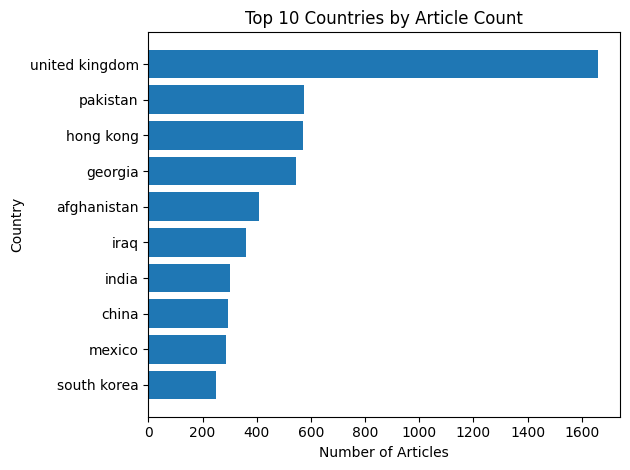

In [23]:
import matplotlib.pyplot as plt

# Count articles per country
country_counts = df_explicit["country"].value_counts().head(10)

plt.figure()
plt.barh(country_counts.index, country_counts.values)
plt.xlabel("Number of Articles")
plt.ylabel("Country")
plt.title("Top 10 Countries by Article Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

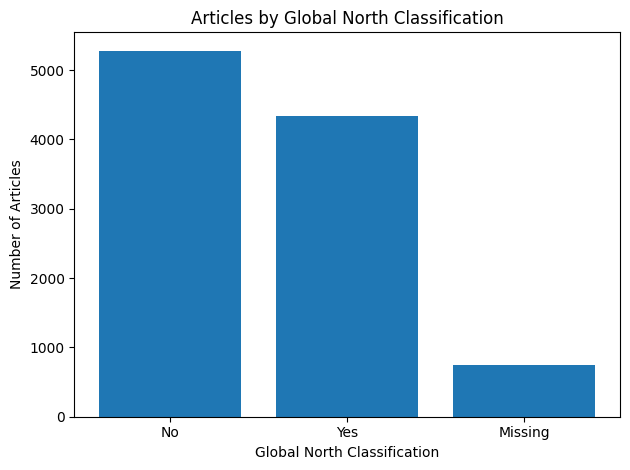

In [25]:
import matplotlib.pyplot as plt

# Count Yes / No / NaN
gn_counts = (
    df_explicit["global_north"]
    .fillna("Missing")
    .value_counts()
)

plt.figure()
plt.bar(gn_counts.index, gn_counts.values)
plt.xlabel("Global North Classification")
plt.ylabel("Number of Articles")
plt.title("Articles by Global North Classification")
plt.tight_layout()
plt.show()
